In [1]:
import torch
import pyro
import json
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pandas as pd
import numpy as np
import seaborn as sns

from ESN import esnet
from dataset.data_loaders import load_dataset, generate_datasets
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, Predictive, MCMC, NUTS, HMC

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

# Time-series forecasting

## Train ESN

Tr: 4882, Val: 1047, Te: 1047
train_embedding shape: (4882, 20)
Test MSE 0.199


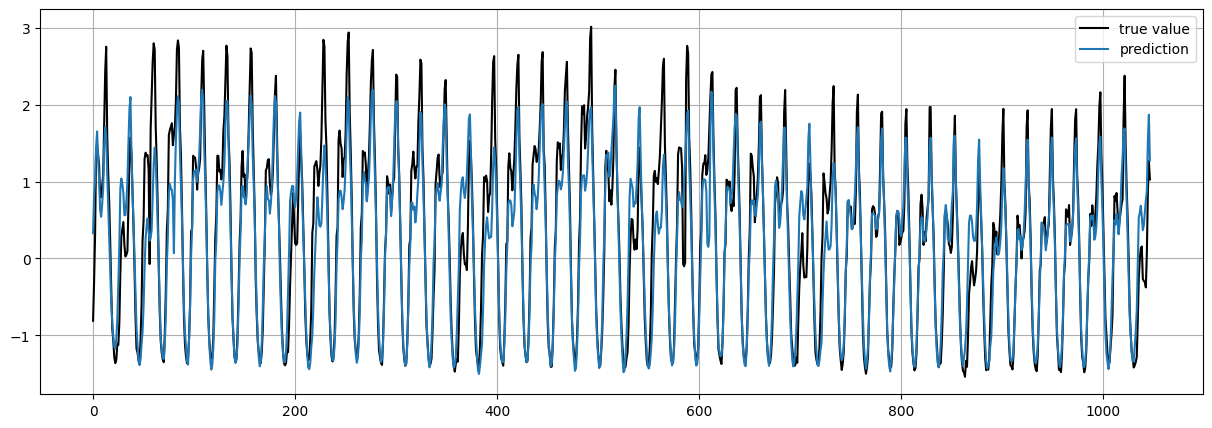

In [112]:
X, Y = load_dataset("acea")

# Set ESN hyperparams
config = json.load(open('ESN/configs/ESN_hyperparams.json', 'r'))

Xtr, Ytr, Xval, Yval, Xte, Yte = generate_datasets(X, Y, test_percent = 0.15, val_percent = 0.15)
print("Tr: {:d}, Val: {:d}, Te: {:d}".format(Xtr.shape[0], Xval.shape[0], Xte.shape[0]))

# Train and compute predictions
# Use the ´_states´ variable if you want the embedding to be the identity
Yte_pred, _, train_states, train_embedding, val_states, val_embedding, test_states, test_embedding = esnet.run_from_config_return_states(Xtr, Ytr, 
                                                                                                            Xte, Yte, 
                                                                                                            config, 
                                                                                                            validation=True,
                                                                                                            Xval=Xval,
                                                                                                            Yval=Yval)

print("train_embedding shape:", train_embedding.shape)
print('Test MSE {:.3f}'.format(mean_squared_error(Yte_pred, Yte)))

# Plot results
fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.plot(Yte_pred, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

In [113]:
n_dims = train_embedding.shape[1]
dtype = 'float32'
train_embedding = train_embedding.astype(dtype)
train_embedding = torch.from_numpy(train_embedding).to(device)
val_embedding = val_embedding.astype(dtype)
val_embedding = torch.from_numpy(val_embedding).to(device)
test_embedding = test_embedding.astype(dtype)
test_embedding = torch.from_numpy(test_embedding).to(device)
Ytr = Ytr.astype(dtype).squeeze()
Ytr = torch.from_numpy(Ytr).to(device)
# Yval = Yval.astype(dtype).squeeze()
# Yval = torch.from_numpy(Yval).to(device)

## Bayesian regression

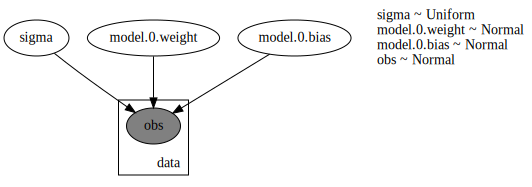

In [27]:
in_features = n_dims
out_features = 1
torch_model = torch.nn.Sequential(
                torch.nn.Linear(in_features, out_features),
                # torch.nn.Linear(in_features, 10),
                # torch.nn.Tanh(),
                # torch.nn.Linear(10, out_features)
            ).to(device)


class BayesianRegression(PyroModule):
    def __init__(self, torch_model, device):
        super().__init__()
        
        pyro.nn.module.to_pyro_module_(torch_model)
        self.model = torch_model
        
        for m in self.model.modules():
            for name, value in list(m.named_parameters(recurse=False)):
                setattr(m, name, PyroSample(dist.Normal(torch.tensor(0., device=device), torch.tensor(1., device=device))
                                                                .expand(value.shape).to_event(value.dim())))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.)).to(device)
        mean = self.model(x).squeeze(-1)
        with pyro.plate("data", x.shape[0], device=device):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

model = BayesianRegression(torch_model, device)
pyro.render_model(model, model_args=(train_embedding, Ytr), render_distributions=True)

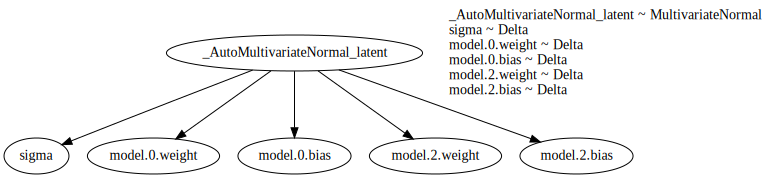

In [5]:
# To enforce all the parameters in the guide on the GPU, since we use an autoguide
if device != 'cpu':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
pyro.render_model(guide, model_args=(train_embedding, Ytr), render_distributions=True)

In [6]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).get_device())

AutoMultivariateNormal.loc -1
AutoMultivariateNormal.scale -1
AutoMultivariateNormal.scale_tril -1


Print starting guide's parameters:

In [8]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy().shape)

AutoMultivariateNormal.loc (222,)
AutoMultivariateNormal.scale (222,)
AutoMultivariateNormal.scale_tril (222, 222)


In [4]:
in_features = n_dims
out_features = 1
torch_model = PyroModule[torch.nn.Sequential](
                PyroModule[torch.nn.Linear](in_features, 10),
                PyroModule[torch.nn.Tanh](),
                PyroModule[torch.nn.Linear](10, out_features)
            ).to(device)

In [ ]:
torch_loss = torch.nn.MSELoss()
torch_optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.001, momentum=0.9)

for epoch in range(100):
    torch_optimizer.zero_grad()
    for data, y in zip(train_embedding, Ytr):
        loss = torch_loss(data, y)
        loss.backward()
        torch_optimizer.step()
    if epoch % 20 == 0:
        print("[iteration %04d] loss: %.4f" % (epoch + 1, loss / Ytr.shape[0]))

In [9]:
adam = Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

num_iterations = 120

# pyro.clear_param_store() # why do we need to clear the param store first?
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(train_embedding, Ytr)
    if j % 20 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / Ytr.shape[0]))

guide.requires_grad_(False)

[iteration 0001] loss: 2.5922
[iteration 0021] loss: 2.3008
[iteration 0041] loss: 1.8530
[iteration 0061] loss: 1.4524
[iteration 0081] loss: 1.2258
[iteration 0101] loss: 1.3510


AutoMultivariateNormal()

Check that the guide's parameters changed:

In [10]:

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoMultivariateNormal.loc Parameter containing:
tensor([-2.5573e+00, -4.6973e-01, -3.9241e-02,  6.2587e-01, -2.0050e-01,
         1.3023e-01, -7.0335e-01,  1.4564e-01,  1.6173e-01,  3.6141e-02,
        -1.5969e-01,  1.4952e-01, -3.7917e-01,  8.0100e-01,  1.0070e+00,
        -7.5115e-01,  6.3287e-01,  8.9040e-01,  5.9524e-01, -2.5724e-01,
        -5.6912e-01,  2.2282e-01, -4.6697e-01, -9.5334e-01,  5.2821e-02,
         6.5527e-02,  5.3948e-01, -1.2996e-01, -1.5280e-01,  4.0341e-01,
        -2.0292e-01, -1.3625e+00,  1.3112e+00, -1.3402e+00, -1.4708e+00,
         1.0019e+00, -7.6404e-01, -8.3449e-01, -5.9102e-01,  3.4770e-01,
         9.1590e-01, -2.5437e-01,  6.4027e-01,  7.0513e-02,  6.9513e-01,
        -1.7398e-02,  3.5936e-01, -2.2290e-01, -3.7455e-01,  1.7866e-01,
        -2.8052e-02, -4.0824e-01,  5.0989e-01, -4.7212e-01, -3.2494e-01,
         3.9049e-02, -5.6097e-01, -2.4770e-01, -1.1609e-01, -7.8709e-02,
         5.3745e-02, -1.2850e-02, -6.7249e-03,  6.8345e-01, -3.6540e-01,
  

In the image above it says that all the parameters are distributed as deltas, but it doesn't look to be the case. Let's plot the histogram of `sigma`:

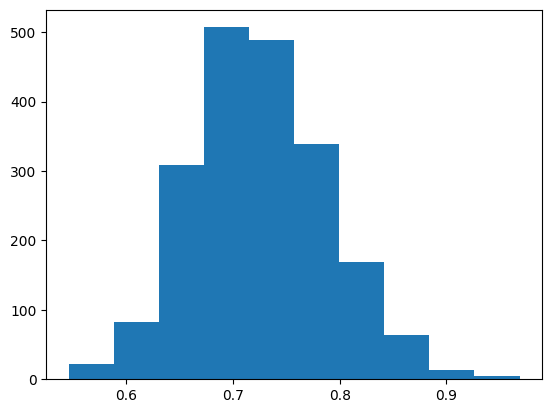

In [30]:
plt.hist([guide()['sigma'] for _ in range(2000)])
plt.show()

It's not a delta, it looks more like a Gaussian. Let's check if `sigma` and `model.2.bias` are correlated: they are. 

In [29]:
a = []
b = []
for n in range(2000):
    g = guide()
    a.append(g["sigma"].item())
    b.append(g["model.2.bias"].squeeze().item())


cov_mat = np.stack((a, b), axis = 0)
 
print(np.cov(cov_mat))

[[0.00410293 0.00016138]
 [0.00016138 0.00337439]]


Is this a bug? No, I asked in [Pyro's forum](https://forum.pyro.ai/t/wrong-distributions-shown-by-render-model-for-an-autoguide/4733).

Print 5 sampled values of the regression parameters

In [ ]:
# samples = {}
sigmas = []
biases = []
weights = []
for n in range(5):
    sample = guide()
    sigmas.append(sample["sigma"].cpu().numpy())
    biases.append(sample["linear.bias"].squeeze().cpu().numpy())
    weights.append(sample["linear.weight"].squeeze().cpu())

weights = torch.stack(weights).T.cpu()

samples = {"sigma" : sigmas, "bias" : biases}

for i in range(weights.shape[0]):
    samples[f"w_{i}"] = weights[i].tolist()

In [12]:
regr_df = pd.DataFrame(samples)
regr_df.head()

,sigma,bias,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,...,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19
0,0.4393554,0.016756738,0.294288,-0.337959,-0.163440,0.209859,0.026286,-0.207688,0.037193,0.061275,...,0.355088,0.476264,0.776525,0.973983,0.066914,-0.688053,-1.454485,0.179895,-0.764678,1.112292
1,0.4344445,0.004083408,0.294591,-0.344228,-0.173666,0.212271,0.051448,-0.236049,0.087292,0.111699,...,0.338152,0.406751,0.643208,1.115319,-0.078707,-0.602925,-1.567111,0.222218,-0.789497,0.828981
2,0.43989837,0.028898783,0.297356,-0.340539,-0.182251,0.206514,0.019745,-0.230932,0.060264,0.076699,...,0.250843,0.355049,0.619124,0.940791,-0.110039,-0.532401,-1.391693,0.280899,-0.839307,0.835020
3,0.43694946,0.009725232,0.297054,-0.341842,-0.156043,0.211483,0.025687,-0.187038,0.093071,0.141394,...,0.313708,0.423631,0.501361,1.174424,-0.112418,-0.720857,-1.397489,0.454053,-0.641253,0.907997
4,0.43548167,0.022285566,0.300593,-0.334460,-0.169080,0.205138,0.038814,-0.209776,0.094340,0.155199,...,0.266177,0.313306,0.548437,1.138317,-0.082687,-0.621817,-1.539834,0.472186,-0.614573,0.756280


Make predictions

In [9]:
num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)(x=test_embedding, y=None)

In [8]:
# not used for now
pred_df = pd.DataFrame(predictive["obs"])
pred_stats = pred_df.describe(percentiles=[0.05,0.5,0.95]).transpose()
pred_stats = pred_stats[["mean", "std", "5%", "95%"]]

In [10]:
def compute_coverage_len(y_test, y_lower, y_upper, verbose=False):
    """ 
    Compute average coverage and length of prediction intervals
    """
    coverage = np.mean((y_test >= y_lower) & (y_test <= y_upper))
    avg_length = np.mean(abs(y_upper - y_lower))
    avg_length = avg_length/(y_test.max()-y_test.min())
    if verbose==True:
        print("PI coverage: {:.2f}, PI avg. length: {:.2f}".format(coverage, avg_length))
    return coverage, avg_length

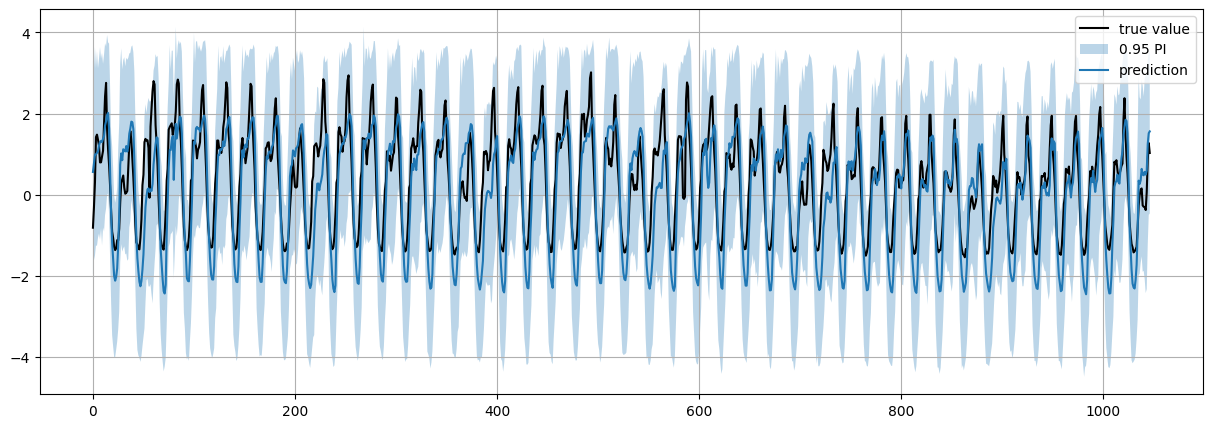

PI coverage: 1.00, PI avg. length: 0.95


In [11]:
# draw and compute the 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive["obs"].cpu().numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.fill_between(np.arange(predictive["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()  
plt.show()

_, _ = compute_coverage_len(Yte.squeeze(), q_low, q_hi, verbose=True)

The output is not calibrated.

## MCMC

In [28]:
nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1500, warmup_steps=500, num_chains=1)
mcmc.run(train_embedding, Ytr)
mcmc.summary(prob=0.95)

Sample: 100%|██████████| 2000/2000 [00:36, 55.55it/s, step size=4.79e-01, acc. prob=0.891]


                          mean       std    median      2.5%     97.5%     n_eff     r_hat
     model.0.bias[0]     -0.00      0.01     -0.00     -0.01      0.01   3380.79      1.00
 model.0.weight[0,0]      0.39      0.00      0.39      0.38      0.39   2489.72      1.00
 model.0.weight[0,1]     -0.26      0.00     -0.26     -0.27     -0.25   3151.41      1.00
 model.0.weight[0,2]     -0.09      0.01     -0.09     -0.11     -0.07   3936.32      1.00
 model.0.weight[0,3]     -0.29      0.01     -0.29     -0.32     -0.26   2772.81      1.00
 model.0.weight[0,4]      0.16      0.02      0.16      0.12      0.19   2383.03      1.00
 model.0.weight[0,5]     -0.07      0.03     -0.07     -0.12     -0.02   2923.91      1.00
 model.0.weight[0,6]      0.14      0.03      0.14      0.08      0.20   2922.95      1.00
 model.0.weight[0,7]     -0.01      0.04     -0.01     -0.08      0.06   3479.81      1.00
 model.0.weight[0,8]     -0.17      0.04     -0.17     -0.25     -0.09   2559.60      1.0

The last two columns are:
- the `effective_sample_size()`
- and the `split_gelman_rubin()`

In [29]:
samples = mcmc.get_samples()

for k, v in samples.items():
    print(f"k: {k}, shape: {v.shape}")

k: model.0.bias, shape: torch.Size([1500, 1])
k: model.0.weight, shape: torch.Size([1500, 1, 20])
k: sigma, shape: torch.Size([1500])


In [13]:
samples = mcmc.get_samples()
hmc_samples_ = {k: v.detach().squeeze().cpu().numpy() for k, v in samples.items()}

# Split  the weights
hmc_samples = {}
for k, v in hmc_samples_.items():
    if k == "sigma" or k == "linear.bias":
        hmc_samples[k] = v
    elif k == "linear.weight":
        for i in range(v.shape[1]):
            hmc_samples[f"w_{i}"] = v[:,i]

chains_df = pd.DataFrame(hmc_samples)
chains_df = chains_df \
    .assign(
        sample_id=lambda x: range(x.shape[0]), 
        chain_sample_id=lambda x: x['sample_id'] % 3000,
        chain_id=lambda x: (x['sample_id'] / 3000).astype(int) + 1
    ) \
    .assign(chain_id=lambda x: 'c_' + x['chain_id'].astype(str))

In [ ]:
fig, axes = plt.subplots(nrows=len(hmc_samples), ncols=2, figsize=(10, 40), constrained_layout=True)

for i, param in enumerate(hmc_samples.keys()):
    sns.histplot(x=param, data=chains_df, hue='chain_id', kde=True, ax=axes[i][0])
    sns.lineplot(x='chain_sample_id', y=param, data=chains_df, hue='chain_id', alpha=0.3, legend=False, ax=axes[i][1])

fig.suptitle('Posterior Samples per Chain', y=1.03)

Find diagnostics, e.g., acceptance rate

In [8]:
mcmc.diagnostics()

{'model.0.bias': OrderedDict([('n_eff',
               tensor([  6.7956,   5.2281,  10.4335, 418.7510,  35.1678,   5.6904,   5.4712,
                         3.6835,   8.2589,   8.2609])),
              ('r_hat',
               tensor([1.0934, 1.2852, 1.1046, 1.0005, 1.0244, 1.3322, 1.2889, 1.7606, 1.2524,
                       1.0490]))]),
 'model.0.weight': OrderedDict([('n_eff',
               tensor([[   6.8677,    8.9342,   11.9473,   77.7780,   10.3829,   12.0516,
                           7.8133,   11.7724,   44.0890,   59.1583,   93.5438,   13.5036,
                          15.8097,   12.1260,   11.9961,   16.5669,   12.9365,  260.0287,
                          16.4124,  184.4136],
                       [   6.9582,    5.8334,    8.4175,    5.0257,    6.6617,   10.4850,
                           9.4832,   37.0226,  174.3657,  131.2388,   35.6440,  394.3566,
                         127.7068,   22.0500,    9.8250,    6.3250,    6.6295,   10.8783,
                           

In [9]:
mcmc.diagnostics()["acceptance rate"]

{'chain 0': 1.0}

In [19]:
nuts_kernel.diagnostics()

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

Make predictions

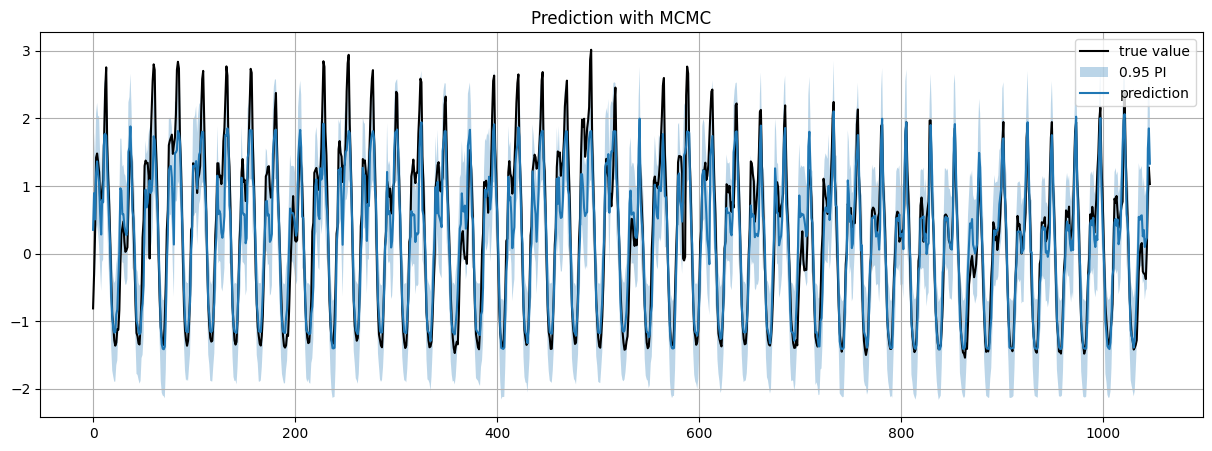

PI coverage: 0.89, PI avg. length: 0.33


In [16]:
predictive_mcmc = Predictive(model, samples)(x=test_embedding, y=None)

# draw and compute the 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_mcmc["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_mcmc["obs"].cpu().numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.fill_between(np.arange(predictive_mcmc["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.title("Prediction with MCMC")
plt.show()

_, _ = compute_coverage_len(Yte.squeeze(), q_low, q_hi, verbose=True)

## Calibration

In the following, we use the technique from the paper [Accurate Uncertainties for Deep Learning Using Calibrated Regression](https://proceedings.mlr.press/v80/kuleshov18a.html)

In [17]:
predictive_val = Predictive(model, samples)(x=val_embedding, y=None)

# draw and compute the 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_val["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_val["obs"].cpu().numpy().squeeze(), axis=0)

_, _ = compute_coverage_len(Yval.squeeze(), q_low, q_hi, verbose=True)

PI coverage: 0.87, PI avg. length: 0.34


In [18]:
# Compute the predicted CDF
predicted_cdf = np.mean(predictive_val["obs"].cpu().numpy().squeeze() <= Yval.squeeze(), axis=0)

In [19]:
# Compute the empirical CDF
empirical_cdf = np.zeros(len(predicted_cdf))
for i, p in enumerate(predicted_cdf):
    empirical_cdf[i] = np.sum(predicted_cdf <= p)/len(predicted_cdf)

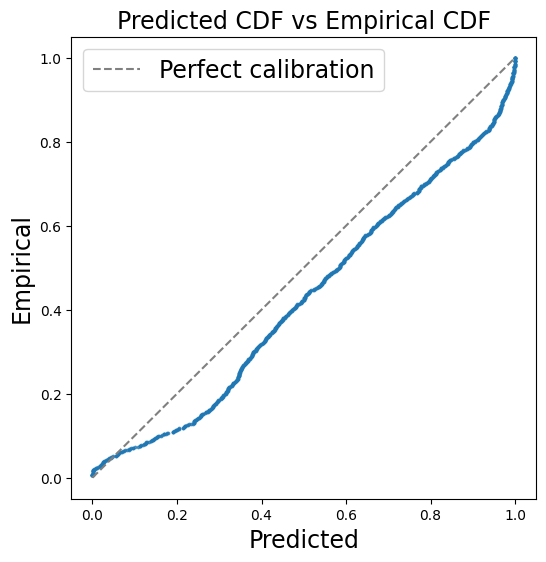

In [20]:
ax = plt.figure(figsize=(6, 6))
ax = plt.gca()
ax.scatter(predicted_cdf, empirical_cdf, alpha=0.7, s=3)
ax.plot([0,1],[0,1],'--', color='grey', label='Perfect calibration')
ax.set_xlabel('Predicted', fontsize=17)
ax.set_ylabel('Empirical', fontsize=17)
ax.set_title('Predicted CDF vs Empirical CDF', fontsize=17)
ax.legend(fontsize=17)

We train the "calibrator" model on the validation dataset

In [21]:
from sklearn.isotonic import IsotonicRegression

isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(empirical_cdf, predicted_cdf)

IsotonicRegression(out_of_bounds='clip')

In [22]:
# Verify that the we get the correct quantiles on the validation set with the isotonic transformation
adjusted_interval = isotonic.transform([(1-target_interval)/2, 1-(1-target_interval)/2])
print("target: [{:.2f}, {:.2f}], adjusted: [{:.2f}, {:.2f}]".format((1-target_interval)/2, 
                                                                    1-(1-target_interval)/2, 
                                                                    adjusted_interval[0], 
                                                                    adjusted_interval[1]))

q_low, q_hi = np.quantile(predictive_val["obs"].cpu().numpy().squeeze(), adjusted_interval, axis=0) # 40-quantile

_, _ = compute_coverage_len(Yval.squeeze(), q_low, q_hi, verbose=True)

target: [0.03, 0.97], adjusted: [0.01, 1.00]
PI coverage: 0.95, PI avg. length: 0.43


We check if the regression on the test dataset is now calibrated

Text(0, 0.5, 'Observed Confidence Level')

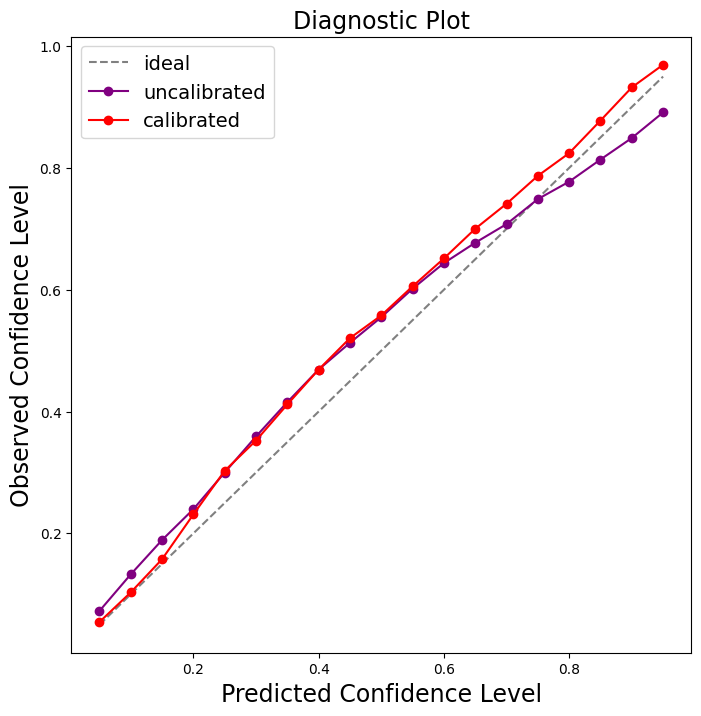

In [23]:
predictive_test = Predictive(model, samples)(x=test_embedding, y=None)

# Check if we obtain a better calibration on the test set
conf_levels = np.arange(start=0.025, stop=0.5, step=0.025)
unc_pcts = []
cal_pcts = []

for cl_lower in conf_levels:
    quants = [cl_lower, 1-cl_lower]
    new_quantiles = isotonic.transform(quants)

    unc_lower, unc_upper = np.quantile(predictive_test["obs"].cpu().numpy().squeeze(), quants, axis=0)
    cal_lower, cal_upper = np.quantile(predictive_test["obs"].cpu().numpy().squeeze(), new_quantiles, axis=0)
       
    perc_within_unc = np.mean((Yte.squeeze() <= unc_upper)&(Yte.squeeze() >= unc_lower))
    perc_within_cal = np.mean((Yte.squeeze() <= cal_upper)&(Yte.squeeze() >= cal_lower))

    unc_pcts.append(perc_within_unc)
    cal_pcts.append(perc_within_cal)
    
conf_levels = conf_levels*2    
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.plot(conf_levels, conf_levels, '--', color='grey', label='ideal')
ax.plot(conf_levels, unc_pcts[::-1], '-o', color='purple', label='uncalibrated')
ax.plot(conf_levels, cal_pcts[::-1], '-o', color='red', label='calibrated')
ax.legend(fontsize=14)
ax.set_title('Diagnostic Plot', fontsize=17)
ax.set_xlabel('Predicted Confidence Level', fontsize=17)
ax.set_ylabel('Observed Confidence Level', fontsize=17)

target: [0.03, 0.97], adjusted: [0.01, 1.00]
Test MSE 0.191
PI coverage: 0.97, PI avg. length: 0.43


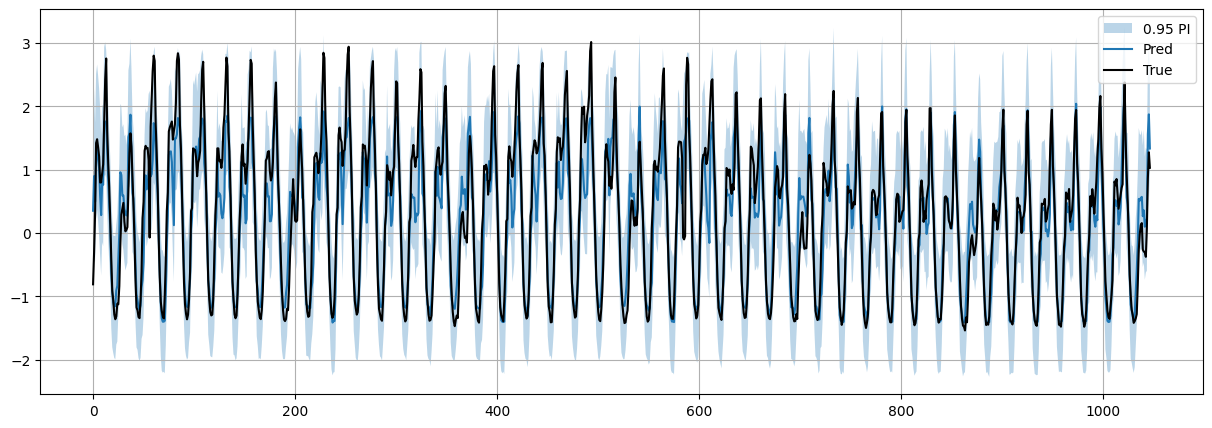

In [24]:
target_interval = 0.95
adjusted_interval = isotonic.transform([(1-target_interval)/2, 1-(1-target_interval)/2])
print("target: [{:.2f}, {:.2f}], adjusted: [{:.2f}, {:.2f}]".format((1-target_interval)/2, 
                                                                    1-(1-target_interval)/2, 
                                                                    adjusted_interval[0], 
                                                                    adjusted_interval[1]))
q_low, q_hi = np.quantile(predictive_test["obs"].cpu().numpy().squeeze(),adjusted_interval , axis=0)
mean = np.mean(predictive_test["obs"].cpu().numpy().squeeze(), axis=0)

plt.figure(figsize=(15, 5))
plt.fill_between(np.arange(predictive_test["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+' PI')
plt.plot(np.arange(predictive_test["obs"].shape[1]), mean, label='Pred')
plt.plot(np.arange(predictive_test["obs"].shape[1]), Yte, label='True', color='k')
plt.legend(loc='upper right')
plt.grid()

print('Test MSE {:.3f}'.format(mean_squared_error(Yte, mean)))
_, _ = compute_coverage_len(Yte.squeeze(), q_low, q_hi, verbose=True)

## Stochastic Search Variable Selection

In [132]:
in_features = 500
out_features = 1

pyro.clear_param_store()

def model_ssvs(x, y):

    m = pyro.param("m", torch.zeros(size=(in_features,out_features)))
    s = pyro.param("s", torch.ones(size=(in_features,out_features)))

    A = pyro.sample("A", dist.Normal(m, s)) # to_event?

    tau = pyro.sample("tau", dist.HalfCauchy(1.))
    lamb = pyro.sample("lambda", dist.HalfCauchy(torch.ones(size=(x.shape[1],)))) # to_event?
    sig = lamb*tau #(lamb**2)*(tau**2)

    gamma = pyro.sample("gamma", dist.Normal(0, sig)).unsqueeze(-1) # to_event?

    mu = torch.matmul(x, (A*gamma)) # do I need the A*gamma or is gamma enough?
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    with pyro.plate("data", x.shape[0], dim=-2):
        obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y)

In [150]:
dist.Normal(torch.tensor([[0],[0],[0]]), torch.tensor([[1],[1],[1]])).batch_shape

torch.Size([3, 1])

In [ ]:
train_states = train_states.astype(dtype)
train_states = torch.from_numpy(train_states).to(device)
test_states = test_states.astype(dtype)
test_states = torch.from_numpy(test_states).to(device)

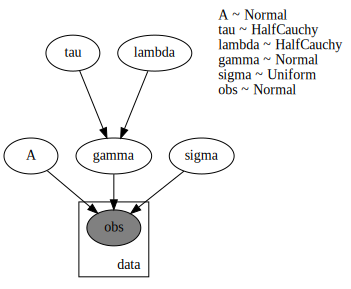

In [134]:
pyro.render_model(model_ssvs, model_args=(train_states, Ytr), render_distributions=True)

In [136]:
nuts_kernel_ssvs = NUTS(model_ssvs)

mcmc_ssvs = MCMC(nuts_kernel_ssvs, num_samples=1000, warmup_steps=0, num_chains=1)
mcmc_ssvs.run(train_states, Ytr)
# mcmc_ssvs.summary(prob=0.95)

Sample: 100%|██████████| 1000/1000 [05:32,  3.01it/s, step size=4.88e-04, acc. prob=0.001]


In [137]:
samples_ssvs = mcmc_ssvs.get_samples()

for k, v in samples_ssvs.items():
    print(f"k: {k}, shape: {v.shape}")

k: A, shape: torch.Size([1000, 500, 1])
k: gamma, shape: torch.Size([1000, 500])
k: lambda, shape: torch.Size([1000, 500])
k: sigma, shape: torch.Size([1000])
k: tau, shape: torch.Size([1000])


In [138]:
predictive_ssvs = Predictive(model_ssvs, samples)(x=test_states, y=None)

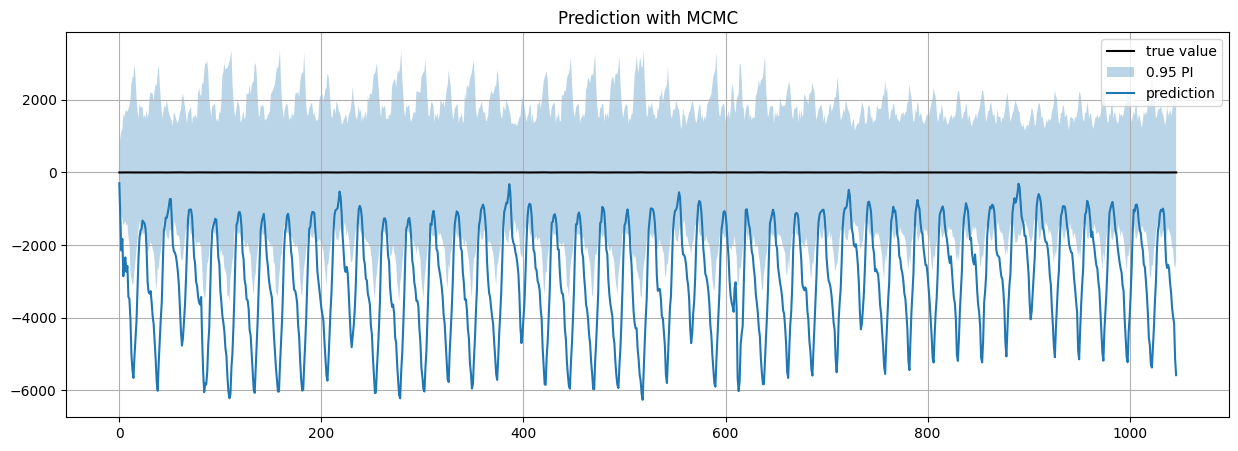

In [139]:
# draw and compute the 95% confidence interval
target_interval = 0.95
q_low, q_hi = np.quantile(predictive_ssvs["obs"].cpu().numpy().squeeze(), [(1-target_interval)/2, 1-(1-target_interval)/2], axis=0) # 40-quantile
mean = np.mean(predictive_ssvs["obs"].cpu().numpy().squeeze(), axis=0)

fig = plt.figure(figsize=(15,5))
plt.plot(Yte, label='true value', color='k')
plt.fill_between(np.arange(predictive_ssvs["obs"].shape[1]), q_low, q_hi, alpha=0.3, label=str(target_interval)+' PI')
plt.plot(mean, label='prediction')
plt.legend(loc='best', fontsize=10)
plt.grid()
plt.title("Prediction with MCMC")
plt.show()

In [140]:
print(f"min: {torch.min(samples_ssvs['A'])}, max: {torch.max(samples_ssvs['A'])}")
print(f"min: {torch.min(samples_ssvs['gamma'])}, max: {torch.max(samples_ssvs['gamma'])}")
print(f"min: {torch.min(samples_ssvs['gamma']*samples_ssvs['A'].squeeze())}, max: {torch.max(samples_ssvs['gamma']*samples_ssvs['A'].squeeze())}")

min: -2.014472723007202, max: 2.006316900253296
min: -2.0285110473632812, max: 2.003324508666992
min: -3.599041700363159, max: 3.9522438049316406


In [94]:
(samples_ssvs['gamma']*samples_ssvs['A'].squeeze()).shape

torch.Size([100, 500])

Warmup:   1%|          | 13/1100 [1:09:40, 321.61s/it, step size=4.54e-08, acc. prob=0.567]


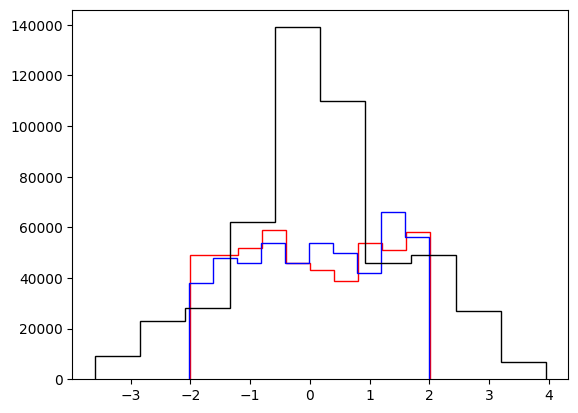

In [141]:
plt.hist(samples_ssvs['A'].flatten(), label="A", color="r", histtype="step")
plt.hist(samples_ssvs['gamma'].flatten(), label="gamma", color="b", histtype="step")
plt.hist((samples_ssvs['gamma']*samples_ssvs['A'].squeeze()).flatten(), label="A*gamma", color="k", histtype="step")
plt.show()